 # Test the tuned Model

 In the last notebook, we have seen the steps to fine tune AlexNet model with MNIST dataset.
 In this notebook, we will load the tuned model shared by NICD and then will test it with MNIST data.

 In the import section below, we have used two new import statements which are torch.nn and matplotlib.pyplot.
 In which, torch.nn provides the basic building blocks for the construction of the neural network, for replacing model layers, and
 matplotlib.pyplot is a collection of functions that make matplotlib work like MATLAB through which we can create figures.

In [28]:
import torch
from torchvision import models, transforms, datasets
import torch.nn as nn
import matplotlib.pyplot as plt

import sklearn.metrics as metrics
import torch.utils.data as data_utils
import pickle


 The Transforms module used in the below snippet helped us in transforming the greyscaled MNIST data into a tensor.


In [12]:
transform = transforms.Compose([
 transforms.Resize(224),
 transforms.ToTensor(),
 # MNIST is greyscale so we stack the image to create 3 channels
 transforms.Lambda(lambda x: x.repeat(3, 1, 1)),
 transforms.Normalize(
 mean=[0.485, 0.456, 0.406],
 std=[0.229, 0.224, 0.225]),
 ])


 Torchvision provides many built-in datasets in the torchvision.datasets module.
 Here, we have downloaded the MNIST dataset and stored it in the directory named as data.
 The dataloader used here combines a dataset and a sampler, and provides an iterable over the given dataset.

In [13]:
mnist_test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
MNIST_test_loader = torch.utils.data.DataLoader(mnist_test_dataset, batch_size=1, shuffle=True)


 In the below snippet, we have created an alexnet model without using the pretrained keyword. This provides the default alexnet model with randomly initialised parameters.
 If we inspect the model, we can see the model architecture with out_feature =1000 in its last layer.

In [14]:
model = models.alexnet()
model

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

 # Redefining the layers
 The task is to classify a given image of a handwritten digit into one of 10 classes representing integer values from 0 to 9, inclusively.
 So we need to replace the last layer with 10 neurons.
 nn. Linear(n,m) is a module that creates single layer feed forward network with n inputs and m output.
 Through which we can update the output of our last layer.

In [15]:
num_ftrs = model.classifier[6].in_features
model.classifier[6] = nn.Linear(num_ftrs,10)


 If we check the model architecture, we can see the last layer out_features was updated to 10.

In [16]:
model

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 


 Now, we have our expected model architecture for MNIST data prediction.
 However, as this model has not been trained it is ot yet capable of making sensible predictions. Instead of training the model with MNIST dataset, we directly loaded the finetuned alexnet model shared by NICD.
 Training a model in a CPU machine will take a long time.
 So with the help of NICD, we finttuned our pretrained alexnet model with MNIST dataset in NICD's GPU machine which took approximately 40 to 50 mins for 50 epochs.

 To load this finetuned model, we need to place the model file (mnist_head_alexnet.pth) in the same directory of our source code.
 Then using torch.load() we can deserialize python's object files to memory.
 Finally, using load_state_dict, we can loads a model’s parameter dictionary using a deserialized state_dict.

 In PyTorch, the learnable parameters (i.e. weights and biases) of an torch.nn.Module model are contained in the model’s parameters (accessed with model.parameters()).
 A state_dict is simply a Python dictionary object that maps each layer to its parameter tensor.
 Note that only layers with learnable parameters (convolutional layers, linear layers, etc.) and registered buffers have entries in the model’s state_dict.

 NOTE: The map_location argument is used here because the model was trained on a computer with a GPU avaliable. This means that the state_dict contains references to the GPU which will cause an error on a device where only a CPU is avaliable. This argument allows us to specify the device which all tensors should be createed on.

In [17]:
model.load_state_dict(torch.load('mnist_head_alexnet.pth',map_location=torch.device('cpu')))
model.eval()


AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

 Since, we are going to test the model directly we are using eval mode in the above snippet.
 Next, we need to pass our MNIST data into our model and predict the output.
 So, using the below code snippet we iterated and picked a single data from our dataset.

In [18]:
sample_image = iter(MNIST_test_loader).next()[0]
sample_image

tensor([[[[-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          ...,
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179]],

         [[-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          ...,
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357]],

         [[-1.8044, -1.8044, -1.8044,  ..., -1.8044, -1.8044, -1.8044],
          [-1.8044, -1.8044, -

 Our sample image is in tensor format.
 To visualise the selected data, we used matplotlib.pyplot to create the figure of the image.

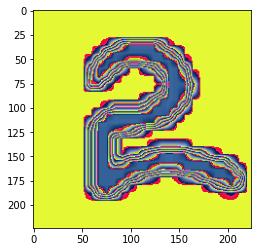

In [19]:
pil_iamge = transforms.ToPILImage()(sample_image.squeeze(0))
plt.imshow(pil_iamge, cmap='gray')


 Finally, we just passed our sample test data into our model and
 model precits the probablities of each tensor[0-9].

In [20]:
pred =model(sample_image)
pred

tensor([[-3.5113e+00, -1.9441e+01,  4.3066e+00,  1.9997e+00, -9.0859e+00,
          3.3929e+00, -1.9847e+00, -4.8916e+00, -1.5456e+00, -1.3226e-02]],
       grad_fn=<AddmmBackward0>)

In [21]:
torch.argmax(pred)


tensor(2)

 Finally, using torch.argmax, a single element tensor, with the highest probability, is returned and that is our expected output.

Performance:
Choosing the right metric is crucial while evaluating machine learning (ML) models.
Also looking at a single metric may not give the whole picture of the problem we are solving, and we may want to use a subset of the metrics discussed in this notebook to have a concrete evaluation of our models.
 
To calculate the performance of our model, let's grab the 100 random data

In [25]:
sample_idx = torch.arange(100)
test_100 = data_utils.Subset(mnist_test_dataset, sample_idx)


MNIST_test_loader = torch.utils.data.DataLoader(test_100, batch_size=1, shuffle=True)

Then pass our test data into our model and collect its predictions and tags. These are the key elements in evaluating our model's performance.

In [26]:
predictionList= []
tags =[]

for image, label in MNIST_test_loader:
    predictionList.append(torch.argmax(model(image)))
    tags.append(label)

predictions = torch.stack(predictionList)
tags = torch.cat(tags)

There are various ways to evaluate a classification model and some of the most popular ones are covered in this notebook.
 
Confusion Matrix:
 
Confusion Matrix is a tabular visualization of the model predictions versus the original labels.
Each row of the confusion matrix represents the instances in a predicted class and each column represents the instances in an actual class.
 
In the below example. we are building a multi-class classification to classify digits from 0 to 9.
We took a test set of 100 MNIST images. Out of 100 the model has predicted 98 of them correctly and has misclassified 2 of them.
 
In the multi-class classification problem, we won’t get TP, TN, FP, and FN values directly as in the binary classification problem. We need to calculate for each class as follows.
 
FN: The False-negative value for a class will be the sum of values of corresponding rows except for the TP value.
FP: The False-positive value for a class will be the sum of values of the corresponding column except for the TP value.
TN: The True Negative value for a class will be the sum of values of all columns and rows except the values of that class that we are calculating the values for.
TP: The True positive value is where the actual value and predicted value are the same.


In [29]:
confMatrix = metrics.confusion_matrix(tags, predictions)
confMatrix

array([[ 8,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0, 14,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  8,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0, 10,  0,  1,  0,  0,  0,  0],
       [ 0,  0,  0,  0, 14,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  6,  0,  1,  0,  0],
       [ 0,  0,  0,  0,  0,  0, 10,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0, 15,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  2,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0, 11]], dtype=int64)

Let us calculate the TP, TN, FP, and FN values for class 3 using the Above formula.
TP: 10 (Class 3)images were identified as True positive.
FN: 1 (Class 5)
FP: 0
TN: 8+14+8+14+6+1+10+15+2+11 = 89
Similarly, we can calculate TP, TN, FP, and FN for the rest of the classes.

Using matplot function we can visualize the Confusion matrix as shown below for better understanding.

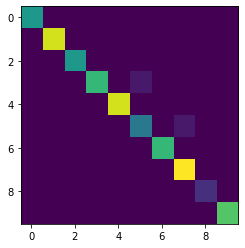

In [30]:
plt.imshow(confMatrix)

Classification Accuracy:
 
Classification accuracy is defined as the number of correct predictions divided by the total number of predictions, multiplied by 100.
So in the above example, out of 100 samples, 98 are predicted correctly, resulting in a classification accuracy of 98%.


In [31]:
metrics.accuracy_score(tags, predictions)

0.98

Precision:
 
There are many cases in which classification accuracy is not a good indicator of model performance.
One of these scenarios is when our class distribution is imbalanced (one class is more frequent than others).
In this case, even if we predict all samples as the most frequent class we would get a high accuracy rate,
which does not make sense at all (because our model is not learning anything, and is just predicting everything as the top class).
 
Therefore we need to look at class-specific performance metrics too. Precision is one of such metrics, which is defined as:
Precision= True_Positive/ (True_Positive+ False_Positive)

In [32]:
metrics.precision_score(tags, predictions, average= 'micro')

0.98

As we can see from the above output, the model has much higher precision in predicting Handwritten digits.

Recall:

The Recall is another important metric, which refers to the percentage of total relevant results correctly classified by our algorithm.
More formally: Recall= True_Positive/ (True_Positive+ False_Negative).

In our case, we got a good recall score of 98%.

In [33]:
metrics.recall_score(tags,predictions, average='micro')

0.98

F1 Score:

Depending on application, We may give higher priority to recall or precision. 
But there are many applications in which both recall and precision are important. 
One popular metric which combines precision and recall is called F1-score, which is the harmonic mean of precision and recall 

F1-score= 2*Precision*Recall/(Precision+Recall)


In [34]:
metrics.f1_score(tags, predictions, average='micro')

0.98

We got a good F1 score of 98%. 
There is always a trade-off between precision and recall of a model, if we want to make the precision too high, we may end up seeing a drop in the recall rate, and vice versa.


All the above metrics were performed with the help of the sklearn.metrics. 
This module implements several loss, score, and utility functions to measure classification performance.

Visualizing the training history of our model:
 
During the training phase of our model (Note_2_FineTuneModel), we recorded the accuracy of each epoch.
Now let's retrieve the accuracy history from the model and visualize it.
 
Firstly, open the model in read-only mode and then store it in a variable called history. This history will now hold the accuracy of all the 50 epochs.

In [38]:
with open('mnist_head_alexnet.pkl', 'rb') as f:
    history = pickle.load(f)

history

[tensor(0.9436, dtype=torch.float64),
 tensor(0.9472, dtype=torch.float64),
 tensor(0.9566, dtype=torch.float64),
 tensor(0.9593, dtype=torch.float64),
 tensor(0.9612, dtype=torch.float64),
 tensor(0.9584, dtype=torch.float64),
 tensor(0.9559, dtype=torch.float64),
 tensor(0.9592, dtype=torch.float64),
 tensor(0.9553, dtype=torch.float64),
 tensor(0.9610, dtype=torch.float64),
 tensor(0.9564, dtype=torch.float64),
 tensor(0.9601, dtype=torch.float64),
 tensor(0.9590, dtype=torch.float64),
 tensor(0.9601, dtype=torch.float64),
 tensor(0.9606, dtype=torch.float64),
 tensor(0.9611, dtype=torch.float64),
 tensor(0.9626, dtype=torch.float64),
 tensor(0.9648, dtype=torch.float64),
 tensor(0.9606, dtype=torch.float64),
 tensor(0.9548, dtype=torch.float64),
 tensor(0.9617, dtype=torch.float64),
 tensor(0.9547, dtype=torch.float64),
 tensor(0.9634, dtype=torch.float64),
 tensor(0.9634, dtype=torch.float64),
 tensor(0.9626, dtype=torch.float64),
 tensor(0.9633, dtype=torch.float64),
 tensor(0.96

Now using Matplot can visualize the accuracy of each epoch.

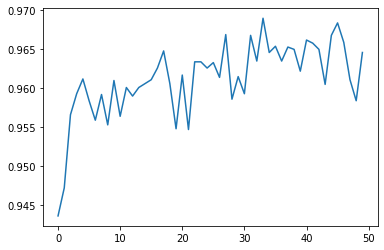

In [36]:
plt.plot(history)